In [1]:
import pandas as pd, numpy as np
import pathlib, codecs
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date,timedelta,datetime
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as Data
import os
from dateutil.relativedelta import relativedelta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# import japanize_matplotlib
plt.rcParams['font.sans-serif']='MS Mincho'
%matplotlib inline

In [2]:
torch.cuda.empty_cache()

In [18]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

## 准备数据

In [2]:
data_n=pd.read_csv('processed_data.csv',
                 index_col=0,
                 parse_dates=["transaction_date"])

In [18]:
#extract data during 2020-02 ~ 2021-11, 22 months
class ConsumerConfidenceExtractor:
    def __init__(self, path, prev_month_start=22, prev_month_end=2 ,extractedColumnIndexes=[]):
        self.month_data = []
        df = pd.read_csv(path)
        df = df.iloc[-prev_month_start:-prev_month_end]
        if len(extractedColumnIndexes) > 0:
            for index in extractedColumnIndexes:
                self.month_data.append(df.loc[:, df.columns[index]].to_numpy())
        else:
            array = df.to_numpy()
            self.month_data = [array[:,i] for i in array.shape[1]]
            
    # return a list with each element being an ndarray as a feature column       
    def getData(self):
        return self.month_data
    
class MonthlyFeatureToDailyFeature:
    #[monthStartStr, monthEndStr]
    def __init__(self, monthStartStr, monthEndStr, monthFeatureList):
        self.monthStart = datetime.strptime(monthStartStr, "%Y-%m")
        self.monthEnd = datetime.strptime(monthEndStr, "%Y-%m") + relativedelta(months=1)
        self.monthFeatureList = monthFeatureList
        
    def convertData(self):
        featureList = [[] for i in range(len(self.monthFeatureList))]
        monthCrt = self.monthStart
        monthIndex = 0
        nextMonth = monthCrt + relativedelta(months=1)
        while monthCrt != self.monthEnd:
            days = (nextMonth - monthCrt).days
            for featureIndex in range(len(self.monthFeatureList)):
                for day in range(days):
                    featureList[featureIndex].append(self.monthFeatureList[featureIndex][monthIndex])
            monthIndex += 1
            monthCrt = nextMonth
            nextMonth = monthCrt + relativedelta(months=1)
        assert (self.monthEnd - self.monthStart).days == len(featureList[0]), "Illegal parameters"
        return [np.array(featureList[i]) for i in range(len(self.monthFeatureList))]
        
featureList = ConsumerConfidenceExtractor(path="./shouhi1_simplified.csv", extractedColumnIndexes=[4,6,8,10,12,14]).getData()
print(pd.DataFrame(np.array(featureList).T))
dailyFeatureList = MonthlyFeatureToDailyFeature(monthStartStr="2020-02", monthEndStr="2021-09", monthFeatureList=featureList).convertData()
consumer_conf = pd.DataFrame(np.array(dailyFeatureList).T)

        0      1      2      3      4      5
0   38.2   37.3   39.4   39.4   36.6   39.5 
1   31.1   30.0   34.7   27.9   31.6   31.9 
2   21.3   21.3   26.1   14.9   22.9   26.8 
3   24.1   25.4   28.2   16.5   26.3   29.3 
4   28.5   30.7   31.6   20.8   31.0   32.9 
5   29.5   31.9   32.9   21.6   31.4   33.2 
6   29.3   31.5   33.0   21.1   31.4   33.0 
7   32.8   35.1   35.4   25.9   34.7   35.5 
8   33.3   35.9   35.2   27.0   35.2   35.7 
9   33.6   36.5   35.5   26.7   35.5   36.8 
10  31.8   34.8   34.4   23.9   34.2   36.2 
11  30.0   32.6   33.4   21.5   32.3   36.1 
12  33.7   36.1   35.0   27.4   36.2   39.0 
13  36.1   37.9   37.0   31.0   38.6   39.8 
14  34.8   36.9   36.5   29.6   36.1   39.0 
15  34.2   36.5   36.4   27.7   36.0   38.6 
16  37.6   38.7   37.9   35.3   38.6   41.0 
17  37.5   39.0   38.2   35.1   37.6   40.0 
18  36.6   38.1   37.9   33.3   37.1   39.8 
19  38.0   39.3   38.8   36.1   37.8   42.4 


In [19]:
consumption_sum = data_n.groupby('transaction_date')['CASHING_SUM'].sum().reset_index()
consumption_sum['dow'] = consumption_sum['transaction_date'].dt.dayofweek
consumption_sum['woy'] = consumption_sum['transaction_date'].dt.isocalendar().week
consumption_sum['day'] = consumption_sum['transaction_date'].dt.day
consumption_sum['month'] = consumption_sum['transaction_date'].dt.month
consumption_sum['year'] = consumption_sum['transaction_date'].dt.year
consumption_sum['holiday'] = 0
consumption_sum.loc[consumption_sum['dow'].isin([5, 6]), 'holiday'] = 1

consumption_sum['is_year_start'] = consumption_sum['transaction_date'].dt.is_year_start*1
consumption_sum['is_year_end'] = consumption_sum['transaction_date'].dt.is_year_end*1
consumption_sum['is_quarter_start'] = consumption_sum['transaction_date'].dt.is_quarter_start*1
consumption_sum['is_quarter_end'] = consumption_sum['transaction_date'].dt.is_quarter_end*1
consumption_sum['is_month_start'] = consumption_sum['transaction_date'].dt.is_month_start*1
consumption_sum['is_month_end'] = consumption_sum['transaction_date'].dt.is_month_end*1

consumption_sum.set_index('transaction_date', inplace=True)

In [20]:
consumption_sum.head(3)

,CASHING_SUM,dow,woy,day,month,year,holiday,is_year_start,is_year_end,is_quarter_start,is_quarter_end,is_month_start,is_month_end
transaction_date,,,,,,,,,,,,,
2018-09-01,538549853.0,5,35,1,9,2018,1,0,0,0,0,1,0
2018-09-02,499484745.0,6,35,2,9,2018,1,0,0,0,0,0,0
2018-09-03,940066850.0,0,36,3,9,2018,0,0,0,0,0,0,0


In [21]:
cate_col = ['dow', 'woy', 'day', 'month','year'] # 需要转换成独热的列
for col in cate_col: consumption_sum[col] = consumption_sum[col].astype(str)
consumption_sum = pd.get_dummies(consumption_sum)

In [22]:
consumption_sum.head(3)

,CASHING_SUM,holiday,is_year_start,is_year_end,is_quarter_start,is_quarter_end,is_month_start,is_month_end,dow_0,dow_1,...,month_4,month_5,month_6,month_7,month_8,month_9,year_2018,year_2019,year_2020,year_2021
transaction_date,,,,,,,,,,,,,,,,,,,,,
2018-09-01,538549853.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2018-09-02,499484745.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2018-09-03,940066850.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0


In [23]:
consumer_conf = consumer_conf.apply(lambda x:x.astype('float'))
consumer_conf.columns = ['conf'+str(i) for i in range(consumer_conf.shape[1])]
# noramlization
consumer_conf.iloc[:,:] = MinMaxScaler().fit_transform(consumer_conf)
consumer_conf.index = consumption_sum['2020-02':'2021-09'].index

In [24]:
# add consumer confidence
consumer_conf = pd.concat([consumption_sum['2020-02':'2021-09'],consumer_conf],axis=1)

In [25]:
consumer_conf.shape

(608, 121)

In [26]:
consumer_conf

,CASHING_SUM,holiday,is_year_start,is_year_end,is_quarter_start,is_quarter_end,is_month_start,is_month_end,dow_0,dow_1,...,year_2018,year_2019,year_2020,year_2021,conf0,conf1,conf2,conf3,conf4,conf5
transaction_date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,5.607440e+08,1,0,0,0,0,1,0,0,0,...,0,0,1,0,1.000000,0.888889,1.000000,1.000000,0.872611,0.814103
2020-02-02,5.383968e+08,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1.000000,0.888889,1.000000,1.000000,0.872611,0.814103
2020-02-03,1.010735e+09,0,0,0,0,0,0,0,1,0,...,0,0,1,0,1.000000,0.888889,1.000000,1.000000,0.872611,0.814103
2020-02-04,5.904618e+08,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1.000000,0.888889,1.000000,1.000000,0.872611,0.814103
2020-02-05,5.228781e+08,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1.000000,0.888889,1.000000,1.000000,0.872611,0.814103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,6.312758e+08,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0.988166,1.000000,0.954887,0.865306,0.949045,1.000000
2021-09-27,1.141604e+09,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0.988166,1.000000,0.954887,0.865306,0.949045,1.000000
2021-09-28,3.987797e+08,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0.988166,1.000000,0.954887,0.865306,0.949045,1.000000


In [27]:
def prepare_data(x, input_window=180, output_window=90):
    """
    准备所有数据，in每次取1-180天的全部数据，decoder_in每次取181-270天的全部特征(不包括任何cash_sum)，out181-270的cash_sum
    """
    in_, decoder_, out_ = [], [], []
    for i in range(len(x)-input_window-output_window+1):
        in_.append(x[i:(i+input_window)])
        decoder_.append(x[(i+input_window):(i+input_window+output_window),1:]) # 保证第0行是cashing_sum
        out_.append(x[(i+input_window):(i+input_window+output_window), 0:1]) # 只取CAHSING_SUM,即target,0:1而不是0是为了增维
    # 最后输入的是之后预测时用的输入
    # pred_input = x[-input_window:]
    return np.array(in_), np.array(decoder_), np.array(out_)

In [ ]:
in_, decoder_, out_ = prepare_data(consumption_sum.values)

In [ ]:
print(in_.shape)
print(decoder_.shape)
print(out_.shape)

将(685,180,105)给编码器，获取编码器最后的h和c
(h.shape=c.shape=(batch_size=685,hidden_size=200)).解码器的输入是(685,90,104)以及最后的h和c，先通过隐藏层变为104->200,最后用线性层把200->1,输出(685,90,1)

In [28]:
class Encoder(nn.Module):
    """
        parameter：
        - input_size: feature size
        - hidden_size: number of hidden units
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers)

    def forward(self, _input):
        batch_size, seq_len, input_size = _input.shape # (100,180,105)
        output, hidden = self.gru(_input.view(seq_len, -1, self.input_size)) 
        return output, hidden
    
    
class Decoder(nn.Module):
    """
        parameter：
        - input_size: 除了cashing的所有特征
        - hidden_size: number of hidden units
        - output_size: number of output 输出每天的CAHSING_SUM，即1
        - num_layers: layers of LSTM to stack
        注意gru和LSTM的区别！！gru只需要h0，而lstm需要h0和c0,输出的也是同理
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = 0.1
        self.input_size = input_size
        self.seq_len = 180  # 编码器的序列长度
        
        self.dropout = nn.Dropout(self.dropout_p)
        self.attn = nn.Linear(self.input_size+self.hidden_size, self.seq_len) # 直接将input跟hidden状态拼在一起，转换成句子长度
        self.attn_combine = nn.Linear(self.input_size+self.hidden_size, self.hidden_size) # 将单个word的embedding跟权重attn_applied拼在一起
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, _input, hidden, encoder_output):
        """
        _input:    (batch_size, seq_len_decoder, input_size)=(100,90,104) 每次只能输入一个序列，为了计算权重
        hidden:    (2, 2,100,200) == (parameter_size ,stack, batch_size, hidden_size) 第一个2是因为hidden包括h和c
        encoder_output:  (seq_len, batch_size, hideen_size) = (180,100,200) 记录了每个单词输出的h_t
        decoder_outputs:  (seq_len_decoder, batch_size, output_size) = (90,100,1)
        """
        batch_size, seq_len_decoder, input_size = _input.shape
        decoder_outputs = torch.zeros(seq_len_decoder, batch_size, self.output_size,device=device)
        for i in range(seq_len_decoder):
            hidden_for_con = hidden.mean(dim=0) # (batch_size, hidden_size) 取到h，然后对2层h求平均
            concat = torch.cat((_input[:,i,:], hidden_for_con), dim=1)  # (batch_size,hidden_size+input_size)
            ##### 权重分配
            attn = self.attn(concat)        # (batch_size, input_size+hidden_size)  ->  (batch_size, seq_len)
            attn_weights = F.softmax(attn, dim=1)        # (batch, seq_len)
            # (batch, 1, hidden_size) <= (batch, 1, seq_len) × (batch, seq_len, hidden_size)
            attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_output.transpose(0, 1).contiguous())
            #####

            concat = torch.cat([_input[:,i,:], attn_applied[:,0,:]], dim=1)        # (batch, hidden_size+input_size)
            # self.attn_combine: 全結合層
            attn_combine = self.attn_combine(concat).unsqueeze(0)        # (batch, hidden_size+input_size) -> (1, batch, hidden_size)
            relu = F.relu(attn_combine)
            output, hidden = self.gru(relu, hidden)
            s, b, h = output.shape # (1,100,200)
            output = self.linear(output.view(s*b, h)) # 第一个维度是batch，所以取0，注意经过了self.out层之后，形状变回了output_size
            assert output.shape == (s*b, self.output_size)
            output = output.view(s, b, self.output_size)
            decoder_outputs[i] = output[0]
        return decoder_outputs, hidden

In [20]:
consumption_sum.shape

(1126, 105)

In [11]:
def train(encoder, decoder, encoder_input, decoder_input, output, batch_size, epoch=1000):
    bs, input_sequence, input_size = encoder_input.shape # (685, 180, 122)
    bs, sequence_size, feature_size = decoder_input.shape # (685,90,121)
    bs, output_sequence, output_size = output.shape  # (685,90,1)
    learning_rate=1e-4
    print("encoder_input_size:",encoder_input.shape)
    print("decoder_input_size:",decoder_input.shape)
    print("decoder_input_size:",output.shape)
    # 转移到gpu
    encoder_input = torch.from_numpy(encoder_input).float().to(device)
    decoder_input = torch.from_numpy(decoder_input).float().to(device)
    output = torch.from_numpy(output).float().to(device)
    # 优化器
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()
    torch_dataset = Data.TensorDataset(encoder_input, decoder_input, output)
    loader = Data.DataLoader(
        # 从数据库中每次抽出batch size个样本
        dataset=torch_dataset,
        batch_size=batch_size,
    )
    # 开始训练
    for i in range(epoch):
        for encoder_input, decoder_input, output in loader:  # 批量取出
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            encoder_output, hidden = encoder(encoder_input)
            # hidden.shape = (2,100,200) == (stack, batch_size, hidden_size)
            decoder_output, hidden = decoder(decoder_input, hidden, encoder_output)
            #print("decoder_output_shape:",decoder_output.shape)        (90,100,1)
            loss = loss_function(decoder_output, output.transpose(0, 1).contiguous())
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch: {}, Loss:{:.5f}'.format(i+1, loss.item()))
                
def predict(encoder, decoder, encoder_input, decoder_input):
    with torch.no_grad():        
        encoder_input = torch.from_numpy(encoder_input).float().to(device)
        decoder_input = torch.from_numpy(decoder_input).float().to(device)
        encoder_output, encoder_hidden = encoder(encoder_input.unsqueeze(0))  # 增维 ->(1,180,105)
        decoder_output, decoder_hidden = decoder(decoder_input.unsqueeze(0), encoder_hidden, encoder_output)  # 增维 ->(1,90,104)
        decoder_output = decoder_output.detach().cpu().numpy()
        return decoder_output.squeeze()

In [29]:
MAX = consumption_sum.CASHING_SUM.max()
X_norm = consumption_sum.copy()
X_norm['CASHING_SUM'] = X_norm['CASHING_SUM']/MAX

In [31]:
X_norm.head(5)

,CASHING_SUM,holiday,is_year_start,is_year_end,is_quarter_start,is_quarter_end,is_month_start,is_month_end,dow_0,dow_1,...,month_4,month_5,month_6,month_7,month_8,month_9,year_2018,year_2019,year_2020,year_2021
transaction_date,,,,,,,,,,,,,,,,,,,,,
2018-09-01,0.348698,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2018-09-02,0.323404,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2018-09-03,0.608670,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
2018-09-04,0.355326,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2018-09-05,0.345733,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


## 为了测试，只训练一次

In [ ]:
# 输出训练集预测结果
start = 0
window = 90
input_days = 180
n_test_set = (len(data_can_use)-input_days)//window
for i in range(n_test_set):
    test_encoder_in = data_can_use[start:start+input_days].values   # 最后的180天，预测未来90天
    test_data = data_can_use.iloc[start+input_days:start+input_days+window, 1:]
    test_decoder_in = test_data.values
    test_out = data_can_use.iloc[start+input_days:start+input_days+window, 0].values
    test_pred = predict(encoder, decoder, test_encoder_in, test_decoder_in)
    test_pred *= MAX
    print('test period: {}~{}\n'.format(test_data.index.min(), test_data.index.max()))
    ############### Eval
    test_true = test_out.squeeze().copy() # 好像这里squeeze对原数组有影响
    test_true *= MAX
    MAPE = abs((test_pred - test_true) / test_true).mean()
    print("MAPE:{:.2%}".format(MAPE))
    start += window
    ############### write to file
    pd.DataFrame(test_pred,index=test_data.index).to_csv('train_{}_round.csv'.format(i),header=False)

total dataset start date: 2018-09-01 00:00:00; end date: 2021-09-30 00:00:00

number of test set: 6
################ROUND 1#################
train period: 2018-09-01 00:00:00~2021-02-02 00:00:00; 
 test period: 2021-02-03 00:00:00~2021-05-03 00:00:00



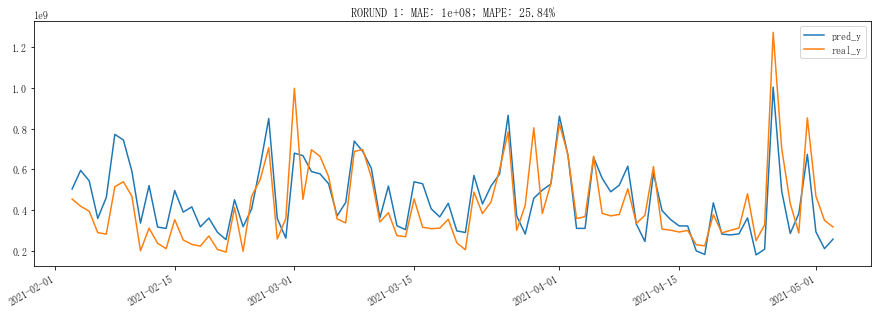

################ROUND 2#################
train period: 2018-09-01 00:00:00~2021-03-04 00:00:00; 
 test period: 2021-03-05 00:00:00~2021-06-02 00:00:00



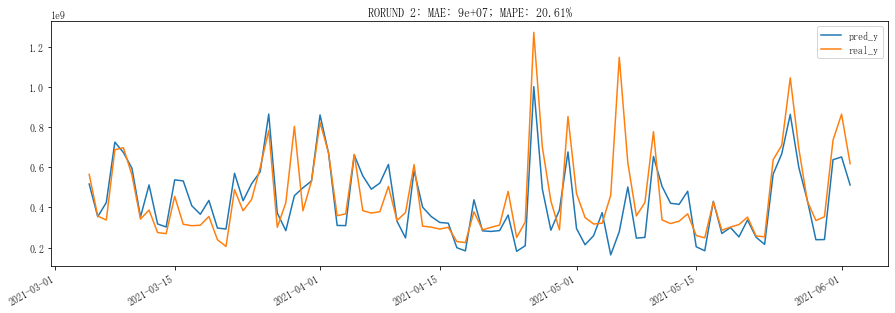

################ROUND 3#################
train period: 2018-09-01 00:00:00~2021-04-03 00:00:00; 
 test period: 2021-04-04 00:00:00~2021-07-02 00:00:00



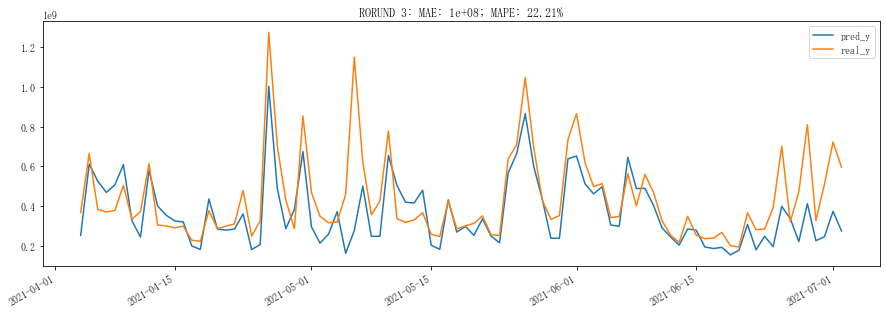

################ROUND 4#################
train period: 2018-09-01 00:00:00~2021-05-03 00:00:00; 
 test period: 2021-05-04 00:00:00~2021-08-01 00:00:00



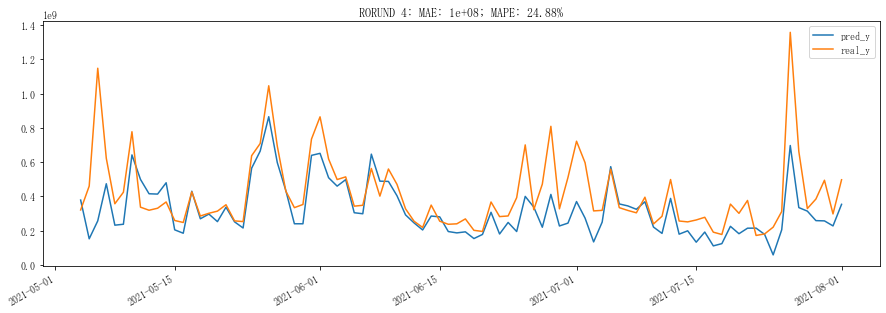

################ROUND 5#################
train period: 2018-09-01 00:00:00~2021-06-02 00:00:00; 
 test period: 2021-06-03 00:00:00~2021-08-31 00:00:00



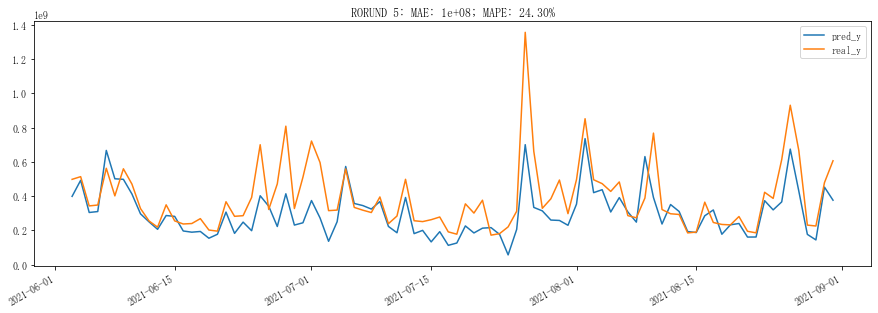

################ROUND 6#################
train period: 2018-09-01 00:00:00~2021-07-02 00:00:00; 
 test period: 2021-07-03 00:00:00~2021-09-30 00:00:00



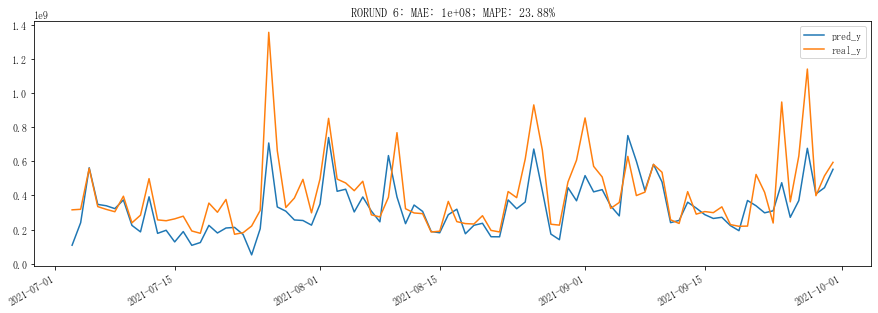

################# FINAL#################
Overall Performance MAE: 1e+08, MAPE: 23.62%


In [33]:
print('total dataset start date: {}; end date: {}\n'.format(X_norm.index.min(), X_norm.index.max()))
total_period = len(X_norm)
output_days =leading_time = 30*3
test_period = 30*9
test_shift = 30
input_days = 180
batch_size = 15
n_test_set = (test_period-leading_time)//test_shift
print('number of test set: {}'.format(n_test_set))
final_score_mae = []
final_score_mape = []
for i in range(1, n_test_set+1):
    print('ROUND {}'.format(i).center(40,'#'))
    # 准备训练数据
    split_time = total_period - test_period + i*test_shift
    data_can_use = X_norm[:split_time]
    test_data = X_norm[split_time:split_time+leading_time]
    encoder_in, decoder_in, out_ = prepare_data(data_can_use.values)
    # 数据尺寸
    bs, input_sequence, input_size = encoder_in.shape # (685, 180, 105)
    bs, sequence_size, feature_size = decoder_in.shape # (685,90,104)
    bs, output_sequence, output_size = out_.shape  # (685,90,1)
    hidden_size = 200
    # 测试数据
    test_encoder_in = data_can_use[-input_days:].values   # 最后的180天，预测未来90天
    test_decoder_in = test_data.iloc[:, 1:].values
    test_out = test_data.CASHING_SUM.values
    print('train period: {}~{}; \n test period: {}~{}\n'.format(data_can_use.index.min(), data_can_use.index.max(), test_data.index.min(), test_data.index.max()))
    ############### Your Model
    # 设置编码器解码器
    if i==1: # 节省时间，就第一轮训练
        encoder = Encoder(input_size, hidden_size).to(device)
        decoder = Decoder(feature_size, hidden_size, output_size).to(device)
        train(encoder, decoder, encoder_in, decoder_in, out_, batch_size)
    test_pred = predict(encoder, decoder, test_encoder_in, test_decoder_in)
    test_pred *= MAX
    ############### Eval
    test_true = test_out.squeeze().copy() # 好像这里squeeze对原数组有影响
    test_true *= MAX
    MAE = abs(test_pred - test_true).mean()
    MAPE = abs((test_pred - test_true) / test_true).mean()
    final_score_mae.append(MAE)
    final_score_mape.append(MAPE)
    ############### Plot
    plt.figure(figsize=(15, 5))
    plt.plot(test_data.index, test_pred, label='pred_y')
    plt.plot(test_data.index, test_true, label='real_y')
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title('RORUND {}: MAE: {:.0}; MAPE: {:.2%}'.format(i, MAE, MAPE))
    plt.show()
    ############### write to file
    pd.DataFrame(test_pred,index=test_data.index).to_csv('{}_round.csv'.format(i),header=False)
print(' FINAL'.center(40,'#'))
print('Overall Performance MAE: {:.0}, MAPE: {:.2%}'.format(np.mean(final_score_mae), np.mean(final_score_mape)))

total dataset start date: 2018-09-01 00:00:00; end date: 2021-09-30 00:00:00

number of test set: 5
################ROUND 0#################
train period: 2018-09-01 00:00:00~2021-06-02 00:00:00; 
 test period: 2021-06-03 00:00:00~2021-08-31 00:00:00

encoder_input_size: (737, 180, 105)
decoder_input_size: (737, 90, 104)
decoder_input_size: (737, 90, 1)
Epoch: 100, Loss:0.00020
Epoch: 200, Loss:0.00014
Epoch: 300, Loss:0.00003
Epoch: 400, Loss:0.00059
Epoch: 500, Loss:0.00012
Epoch: 600, Loss:0.00011
Epoch: 700, Loss:0.00003
Epoch: 800, Loss:0.00008
Epoch: 900, Loss:0.00003
Epoch: 1000, Loss:0.00002


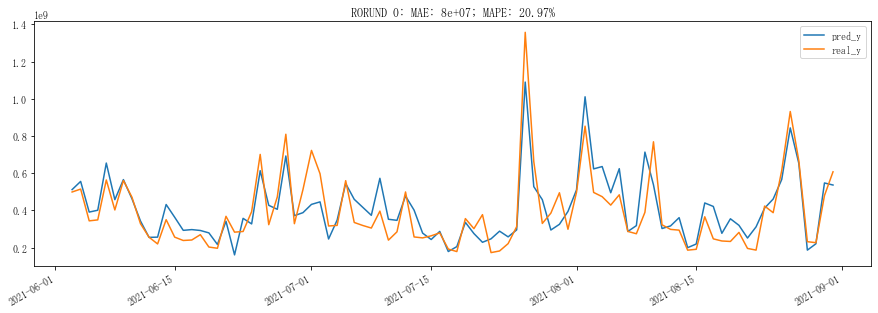

################# FINAL#################
Overall Performance MAE: 8e+07, MAPE: 20.97%


In [12]:
print('total dataset start date: {}; end date: {}\n'.format(X_norm.index.min(), X_norm.index.max()))
total_period = len(X_norm)
output_days =leading_time = 30*3
test_period = 30*4
test_shift = 6
input_days = 180
batch_size = 15
n_test_set = (test_period-leading_time)//test_shift
print('number of test set: {}'.format(n_test_set))
final_score_mae = []
final_score_mape = []
for i in range(1, n_test_set+1):
    print('ROUND {}'.format(i).center(40,'#'))
    # 准备训练数据
    split_time = total_period - test_period + i*test_shift
    data_can_use = X_norm[:split_time]
    test_data = X_norm[split_time:split_time+leading_time]
    encoder_in, decoder_in, out_ = prepare_data(data_can_use.values)
    # 数据尺寸
    bs, input_sequence, input_size = encoder_in.shape # (685, 180, 105)
    bs, sequence_size, feature_size = decoder_in.shape # (685,90,104)
    bs, output_sequence, output_size = out_.shape  # (685,90,1)
    hidden_size = 200
    # 测试数据
    test_encoder_in = data_can_use[-input_days:].values   # 最后的180天，预测未来90天
    test_decoder_in = test_data.iloc[:, 1:].values
    test_out = test_data.CASHING_SUM.values
    print('train period: {}~{}; \n test period: {}~{}\n'.format(data_can_use.index.min(), data_can_use.index.max(), test_data.index.min(), test_data.index.max()))
    
    ############### Your Model
    # 设置编码器解码器
    encoder = Encoder(input_size, hidden_size).to(device)
    decoder = Decoder(feature_size, hidden_size, output_size).to(device)
    train(encoder, decoder, encoder_in, decoder_in, out_, batch_size)
    test_pred = predict(encoder, decoder, test_encoder_in, test_decoder_in)
    test_pred *= MAX
    ############### Eval
    test_true = test_out.squeeze()
    test_true *= MAX
    MAE = abs(test_pred - test_true).mean()
    MAPE = abs((test_pred - test_true) / test_true).mean()
    final_score_mae.append(MAE)
    final_score_mape.append(MAPE)
    
    ############### Plot
    plt.figure(figsize=(15, 5))
    plt.plot(test_data.index, test_pred, label='pred_y')
    plt.plot(test_data.index, test_true, label='real_y')
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title('RORUND {}: MAE: {:.0}; MAPE: {:.2%}'.format(i, MAE, MAPE))
    plt.show()
    if i!=n_test_set: # 不知道是不是要完全删除后面的round才能够正常运行
        del encoder
        del decoder
    
print(' FINAL'.center(40,'#'))
print('Overall Performance MAE: {:.0}, MAPE: {:.2%}'.format(np.mean(final_score_mae), np.mean(final_score_mape)))

total dataset start date: 2018-09-01 00:00:00; end date: 2021-09-30 00:00:00

number of test set: 5
################ROUND 1#################
train period: 2018-09-01 00:00:00~2021-06-08 00:00:00; 
 test period: 2021-06-09 00:00:00~2021-09-06 00:00:00

encoder_input_size: (743, 180, 115)
decoder_input_size: (743, 90, 114)
decoder_input_size: (743, 90, 1)
Epoch: 100, Loss:0.00021
Epoch: 200, Loss:0.00020
Epoch: 300, Loss:0.00013
Epoch: 400, Loss:0.00014
Epoch: 500, Loss:0.00004
Epoch: 600, Loss:0.00003
Epoch: 700, Loss:0.00003
Epoch: 800, Loss:0.00004
Epoch: 900, Loss:0.00001
Epoch: 1000, Loss:0.00005


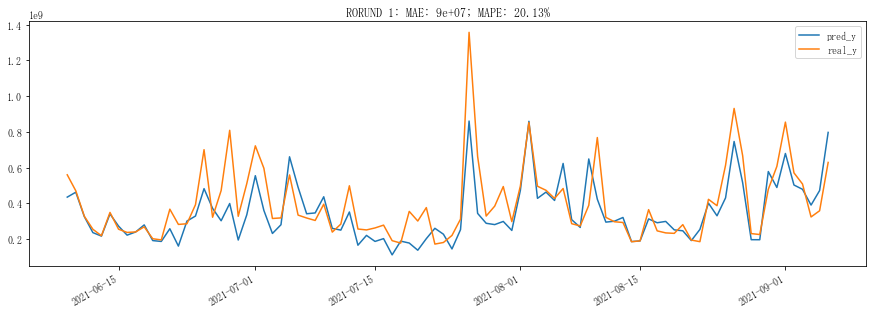

################ROUND 2#################
train period: 2018-09-01 00:00:00~2021-06-14 00:00:00; 
 test period: 2021-06-15 00:00:00~2021-09-12 00:00:00

encoder_input_size: (749, 180, 115)
decoder_input_size: (749, 90, 114)
decoder_input_size: (749, 90, 1)
Epoch: 100, Loss:3043615152537600.00000
Epoch: 200, Loss:3043614615666688.00000
Epoch: 300, Loss:3043614615666688.00000
Epoch: 400, Loss:3043614615666688.00000
Epoch: 500, Loss:3043614615666688.00000
Epoch: 600, Loss:3043614078795776.00000
Epoch: 700, Loss:3043613810360320.00000
Epoch: 800, Loss:3043613541924864.00000
Epoch: 900, Loss:3043613541924864.00000
Epoch: 1000, Loss:3043613273489408.00000


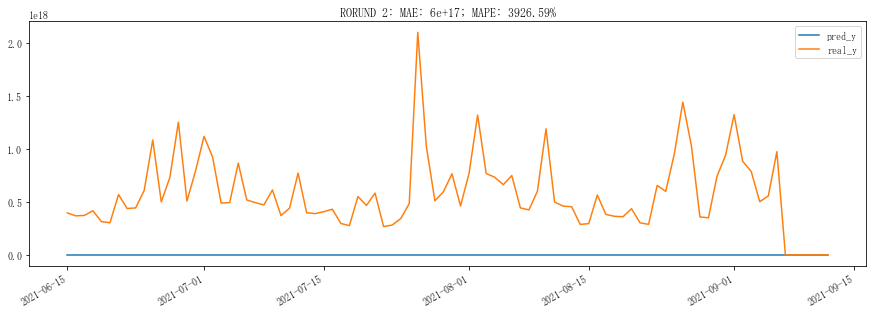

################ROUND 3#################
train period: 2018-09-01 00:00:00~2021-06-20 00:00:00; 
 test period: 2021-06-21 00:00:00~2021-09-18 00:00:00

encoder_input_size: (755, 180, 115)
decoder_input_size: (755, 90, 114)
decoder_input_size: (755, 90, 1)


KeyboardInterrupt: 

In [91]:
print('total dataset start date: {}; end date: {}\n'.format(X_norm.index.min(), X_norm.index.max()))
total_period = len(X_norm)
output_days =leading_time = 30*3
test_period = 30*4
test_shift = 6
input_days = 180
batch_size = 15
n_test_set = (test_period-leading_time)//test_shift
print('number of test set: {}'.format(n_test_set))
final_score_mae = []
final_score_mape = []
for i in range(1, n_test_set+1):
    print('ROUND {}'.format(i).center(40,'#'))
    # 准备训练数据
    split_time = total_period - test_period + i*test_shift
    data_can_use = X_norm[:split_time]
    test_data = X_norm[split_time:split_time+leading_time]
    encoder_in, decoder_in, out_ = prepare_data(data_can_use.values)
    # 数据尺寸
    bs, input_sequence, input_size = encoder_in.shape # (685, 180, 105)
    bs, sequence_size, feature_size = decoder_in.shape # (685,90,104)
    bs, output_sequence, output_size = out_.shape  # (685,90,1)
    hidden_size = 200
    # 测试数据
    test_encoder_in = data_can_use[-input_days:].values   # 最后的180天，预测未来90天
    test_decoder_in = test_data.iloc[:, 1:].values
    test_out = test_data.CASHING_SUM.values
    print('train period: {}~{}; \n test period: {}~{}\n'.format(data_can_use.index.min(), data_can_use.index.max(), test_data.index.min(), test_data.index.max()))
    
    ############### Your Model
    # 设置编码器解码器
    encoder = Encoder(input_size, hidden_size).to(device)
    decoder = Decoder(feature_size, hidden_size, output_size).to(device)
    train(encoder, decoder, encoder_in, decoder_in, out_, batch_size)
    test_pred = predict(encoder, decoder, test_encoder_in, test_decoder_in)
    test_pred *= MAX
    ############### Eval
    test_true = test_out.squeeze()
    test_true *= MAX
    MAE = abs(test_pred - test_true).mean()
    MAPE = abs((test_pred - test_true) / test_true).mean()
    final_score_mae.append(MAE)
    final_score_mape.append(MAPE)
    
    ############### Plot
    plt.figure(figsize=(15, 5))
    plt.plot(test_data.index, test_pred, label='pred_y')
    plt.plot(test_data.index, test_true, label='real_y')
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title('RORUND {}: MAE: {:.0}; MAPE: {:.2%}'.format(i, MAE, MAPE))
    plt.show()
    if i!=n_test_set: # 不知道是不是要完全删除后面的round才能够正常运行
        del encoder
        del decoder
    
print(' FINAL'.center(40,'#'))
print('Overall Performance MAE: {:.0}, MAPE: {:.2%}'.format(np.mean(final_score_mae), np.mean(final_score_mape)))

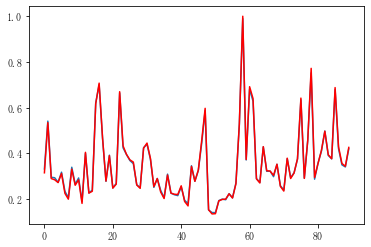

In [14]:
def test_train_result(number):
    number=10
    a=encoder_in[number]
    b=decoder_in[number]
    c=out_[number]
    a=torch.from_numpy(a).float().to(device)
    b=torch.from_numpy(b).float().to(device)
    c=torch.from_numpy(c).float().to(device)
    output,hidden = encoder(a.unsqueeze(0))
    decoder_output, _ = decoder(b.unsqueeze(0), hidden,output)
    plt.plot(decoder_output.squeeze().detach().cpu().numpy())
    plt.plot(c.squeeze().detach().cpu().numpy(),color='r')
test_train_result(100)

增加了时间特征序列之后的效果

total dataset start date: 2018-09-01 00:00:00; end date: 2021-09-30 00:00:00

number of test set: 5
################ROUND 1#################
train period: 2018-09-01 00:00:00~2021-06-08 00:00:00; 
 test period: 2021-06-09 00:00:00~2021-09-06 00:00:00

encoder_input_size: (743, 180, 121)
decoder_input_size: (743, 90, 120)
decoder_input_size: (743, 90, 1)
Epoch: 100, Loss:0.00029
Epoch: 200, Loss:0.00009
Epoch: 300, Loss:0.00014
Epoch: 400, Loss:0.00026
Epoch: 500, Loss:0.00002
Epoch: 600, Loss:0.00004
Epoch: 700, Loss:0.00008
Epoch: 800, Loss:0.00008
Epoch: 900, Loss:0.00002
Epoch: 1000, Loss:0.00002


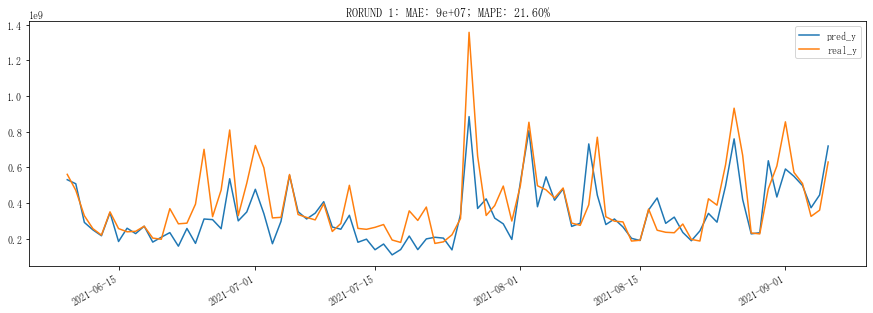

################ROUND 2#################
train period: 2018-09-01 00:00:00~2021-06-14 00:00:00; 
 test period: 2021-06-15 00:00:00~2021-09-12 00:00:00

encoder_input_size: (749, 180, 121)
decoder_input_size: (749, 90, 120)
decoder_input_size: (749, 90, 1)
Epoch: 100, Loss:3043615152537600.00000


KeyboardInterrupt: 

In [13]:
print('total dataset start date: {}; end date: {}\n'.format(X_norm.index.min(), X_norm.index.max()))
total_period = len(X_norm)
output_days =leading_time = 30*3
test_period = 30*4
test_shift = 6
input_days = 180
batch_size = 15
n_test_set = (test_period-leading_time)//test_shift
print('number of test set: {}'.format(n_test_set))
final_score_mae = []
final_score_mape = []
for i in range(1, n_test_set+1):
    print('ROUND {}'.format(i).center(40,'#'))
    # 准备训练数据
    split_time = total_period - test_period + i*test_shift
    data_can_use = X_norm[:split_time]
    test_data = X_norm[split_time:split_time+leading_time]
    encoder_in, decoder_in, out_ = prepare_data(data_can_use.values)
    # 数据尺寸
    bs, input_sequence, input_size = encoder_in.shape # (685, 180, 105)
    bs, sequence_size, feature_size = decoder_in.shape # (685,90,104)
    bs, output_sequence, output_size = out_.shape  # (685,90,1)
    hidden_size = 200
    # 测试数据
    test_encoder_in = data_can_use[-input_days:].values   # 最后的180天，预测未来90天
    test_decoder_in = test_data.iloc[:, 1:].values
    test_out = test_data.CASHING_SUM.values
    print('train period: {}~{}; \n test period: {}~{}\n'.format(data_can_use.index.min(), data_can_use.index.max(), test_data.index.min(), test_data.index.max()))
    
    ############### Your Model
    # 设置编码器解码器
    encoder = Encoder(input_size, hidden_size).to(device)
    decoder = Decoder(feature_size, hidden_size, output_size).to(device)
    train(encoder, decoder, encoder_in, decoder_in, out_, batch_size)
    test_pred = predict(encoder, decoder, test_encoder_in, test_decoder_in)
    test_pred *= MAX
    ############### Eval
    test_true = test_out.squeeze()
    test_true *= MAX
    MAE = abs(test_pred - test_true).mean()
    MAPE = abs((test_pred - test_true) / test_true).mean()
    final_score_mae.append(MAE)
    final_score_mape.append(MAPE)
    
    ############### Plot
    plt.figure(figsize=(15, 5))
    plt.plot(test_data.index, test_pred, label='pred_y')
    plt.plot(test_data.index, test_true, label='real_y')
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title('RORUND {}: MAE: {:.0}; MAPE: {:.2%}'.format(i, MAE, MAPE))
    plt.show()
    
print(' FINAL'.center(40,'#'))
print('Overall Performance MAE: {:.0}, MAPE: {:.2%}'.format(np.mean(final_score_mae), np.mean(final_score_mape)))